# CPN generator

In [1]:
import pandas as pd
import numpy as np
import spacy
import gensim
from collections import Counter 
import sklearn.cluster
import random

random.seed(0)

In [2]:
# data import
data = pd.read_csv(r'../../data/nueva_data/propiedades_codigo.csv', delimiter="\t")
model = gensim.models.KeyedVectors.load_word2vec_format( 
    r'../../data/SBW-vectors-300-min5.bin', # using the spanish billion words embeddings
    binary=True # the model is in binary format
)

In [4]:
data.head(5)

,Concepto,Respuesta,Codigo
0,granito,tierra,terrestre
1,granito,rugoso,texturas
2,granito,construcción,material_construccion
3,granito,desagradable al tacto,texturas
4,granito,raspa,lastimar


In [6]:
# Configuracion de spacy
nlp = spacy.load('es_core_news_sm')
# nlp.Defaults.stop_words.add("my_new_stopword")

## Funciones Importantes

In [8]:

def clean_text(text):
    """
    Recive a string and return the string in tokens without punctuations
    and in lowercase
    """
    # for each token in the sentence add to the list if is not a punctuation
    return [t for t in nlp(text.lower()) if not t.is_punct]


def normalize(tokens):
    """
    Recive al list of string and return in one string without stop words
    """
    # for each token if is not a stop word add the word to the list
    words = [t.orth_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(words))


def lematize(tokens):
    """
    Recive al list of string and return in one string without stop words 
    and Lematized
    """
    # for each token if is not a stop word add the lemma of the word in the list
    lemmas = [t.lemma_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(lemmas))

def to_vector(texto,model):
    """ 
    Receives a sentence string along with a word embedding model and 
    returns the vector representation of the sentence
    """
    tokens = texto.split() # splits the text by space and returns a list of words
    vec = np.zeros(300) # creates an empty vector of 300 dimensions
    for word in tokens: # iterates over the sentence
        if word in model: # checks if the word is both in the word embedding
            vec += model[word] # adds every word embedding to the vector
    return vec / np.linalg.norm(vec) # divides the vector by their normal


# Preprocesamiento de los datos

In [9]:
pd.options.mode.chained_assignment = None # Para evitar que se muestre warnings

# Normalizacion de los conceptos, descripciones y codificaciones
for i in range(len(data)):
    data['Respuesta'][i] = normalize(clean_text(data['Respuesta'][i]))

## Generación de Matriz de los datos

In [10]:
# Creation of the matrix to make the clustering process
descriptions_matrix = np.zeros( # creatign an empty matrix
    (
        len(data), # the number of data points
        len(model['hola']) # the number of components of the word embedding
    )
)

# matrix filling 
for i,description in enumerate(data['Respuesta']):
    vector = to_vector(description,model)
    descriptions_matrix[i,] = vector

# Concatenate the matrix with the data of each observation
data_matrix = np.concatenate([descriptions_matrix,data], axis=1)

#--------------------------------------------------------------------------------------
# This is the important matrix
# Remove of the 'Nan' data
data_matrix_without_nan = data_matrix[~pd.isnull(data_matrix[:,:300]).any(axis=1)]
#--------------------------------------------------------------------------------------

# reduce the matrix to the importan
data_matrix_without_nan = np.concatenate(
    (data_matrix_without_nan[:,:300],                       # Vector of the description
    np.reshape(data_matrix_without_nan[:,300], (-1, 1)),    # Cue/Concept
    np.reshape(data_matrix_without_nan[:,302], (-1, 1)),    # Codification
    np.reshape(data_matrix_without_nan[:,301], (-1, 1))     # Description of the cue
    ),
    axis = 1
)

<ipython-input-8-89365e79bd8b>:42: RuntimeWarning: invalid value encountered in true_divide


## Testing random generations

In [17]:
# Generation of test-train data

from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

In [18]:
rand_acc = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        counter += test[i,301] == np.random.choice(train_codes)
    rand_acc.append(counter/len_test)

print(np.mean(rand_acc))
print(np.std(rand_acc))


0.000846629762292413
0.00047635098789735567


In [19]:
rand_acc_top3 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(train_codes)
            if val:
                counter += val
                break
    rand_acc_top3.append(counter/len_test)

print(np.mean(rand_acc_top3))
print(np.std(rand_acc_top3))

0.0020514490394008466
0.00044409578954691806


In [20]:
rand_acc_top5 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        for _ in range(5):
            val = test[i,301] == np.random.choice(train_codes)
            if val:
                counter += val
                break
    rand_acc_top5.append(counter/len_test)

print(np.mean(rand_acc_top5))
print(np.std(rand_acc_top5))

0.0027678280690328883
0.0005545225127296126


In [21]:
rand_acc_top10 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        for _ in range(10):
            val = test[i,301] == np.random.choice(train_codes)
            if val:
                counter += val
                break
    rand_acc_top10.append(counter/len_test)

print(np.mean(rand_acc_top10))
print(np.std(rand_acc_top10))

0.0056007815043959625
0.001116667417745506


In [22]:
rand_acc_top50 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        for _ in range(50):
            val = test[i,301] == np.random.choice(train_codes)
            if val:
                counter += val
                break
    rand_acc_top50.append(counter/len_test)

print(np.mean(rand_acc_top50))
print(np.std(rand_acc_top50))

0.030608922175187236
0.0017199755970360474


In [23]:
rand_concept_acc = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        counter += test[i,301] == np.random.choice(concept_cluster[test[i,300]])
    rand_concept_acc.append(counter/len_test)

print(np.mean(rand_concept_acc))
print(np.std(rand_concept_acc))


0.013741452295669162
0.0005310812904689056


In [24]:
rand_concept_acc_top3 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(concept_cluster[test[i,300]])
            if val:
                counter += val
                break
    rand_concept_acc_top3.append(counter/len_test)

print(np.mean(rand_concept_acc_top3))
print(np.std(rand_concept_acc_top3))

0.041322044936502766
0.0019791040571830345


In [25]:
rand_concept_acc_top5 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(concept_cluster[test[i,300]])
            if val:
                counter += val
                break
    rand_concept_acc_top5.append(counter/len_test)

print(np.mean(rand_concept_acc_top5))
print(np.std(rand_concept_acc_top5))

0.03995441224356887
0.0029569354828385525


In [26]:
rand_concept_acc_top10 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(concept_cluster[test[i,300]])
            if val:
                counter += val
                break
    rand_concept_acc_top10.append(counter/len_test)

print(np.mean(rand_concept_acc_top10))
print(np.std(rand_concept_acc_top10))

0.04291761641159232
0.00209669293806646


In [27]:
rand_concept_acc_top50 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(concept_cluster[test[i,300]])
            if val:
                counter += val
                break
    rand_concept_acc_top50.append(counter/len_test)

print(np.mean(rand_concept_acc_top50))
print(np.std(rand_concept_acc_top50))

0.041028980788016936
0.0017322612931644926


## Model Creation

In [11]:
# Class creation
class PLT_processor:

    def __init__(self, method = 0, n_clusters = 500):
        """
        Recives the type of method to use, 
        - 0: Clasify using K-Means (Simple)
        - 1: Clasify to the codification with the same concept 
        """
        self.n_clusters = n_clusters
        self.method = method # Method of Processing the data
        self.KMeans_dict = {}
        self.KMeans_categories = {}

        if method == 1:
            self.inverse_concept_cluster = {}
            self.concept_cluster = {}

        self.topk = np.zeros((test.shape[0],500))

    def most_frequent(self, List): 
        """
        Recives a list of words, and return the word most frequente of
        the list
        """
        # ? Agregar la frase 'PENDIENTE' en caso de que haya multiples codificaciones con la misma frecuencia ?
        occurence_count = Counter(List) 
        return occurence_count.most_common(1)[0][0] 


    def model_train(self, train):
        """
        Recives the train dataset and the number of clusters to train 
        the k-means model
        """
        
        # If the number of clusters is less than the data points aply K Means
        if(len(train)>self.n_clusters):
            # creates de k-means object
            self.kemean = sklearn.cluster.KMeans(n_clusters=self.n_clusters, random_state=0)
            # Train the k-means algorithm
            self.kemean.fit(train[:,:300])

            # print(self.kemean.n_clusters)
            # Dataframe of train dataset
            df = pd.DataFrame(
                np.concatenate([
                    np.reshape(train[:,301], (-1, 1)),          # Human codification
                    np.reshape(self.kemean.labels_, (-1, 1)),   # Number of the KMean centroid
                    np.reshape(train[:,300], (-1, 1))           # Concept of the codification
                    ], axis=1), 
                columns=['Human', 'KMeans', 'Concept'])
        # Else if the number of clusters is equal than the data points set a number to each point
        elif(len(train)==self.n_clusters):
             # Dataframe of train dataset
            df = pd.DataFrame(
                np.concatenate([
                    np.reshape(train[:,301], (-1, 1)),          # Human codification
                    np.reshape(range(self.n_clusters), (-1, 1)),   # Number of the KMean centroid
                    np.reshape(train[:,300], (-1, 1))           # Concept of the codification
                    ], axis=1), 
                columns=['Human', 'KMeans', 'Concept'])

            self.cluster_centers_2 = train[:,:300].astype(float)

        # create a dictionary of all the humans codifications for each Cluster
        self.KMeans_dict = df.groupby(by='KMeans')['Human'].apply(list).to_dict()

        # Fill a dictionary with the most frecuent value in the centroid
        for key, val in self.KMeans_dict.items():
            self.KMeans_categories[key] = self.most_frequent(val)
        
        # Generates the prediction for the train dataset
        df['KM_Prediction'] = df['KMeans'].map(self.KMeans_categories)

        if self.method == 1:
            # dictionary of the codifications that doesn't show in a concept
            self.not_concept_cluster = {
                i:[False if j in np.unique(df['KMeans'][df['Concept']==i]) else True for j in range(self.n_clusters)] 
                for i in np.unique(df['Concept'])
                }
            # dictionary of clusters for each concept
            self.concept_cluster = {
                i:np.unique(df['KMeans'][df['Concept']==i]) for i in np.unique(df['Concept'])
                }
        # return self.kemean.inertia_

    
    def get_distances(self, test):
        """
        recives the test data to calculate the distances of each frase, return 
        a matrix with the distances sorted
        """

        # Distance matrix of each test point to each cluster center
        distance_matrix = np.zeros((test.shape[0],self.n_clusters))

        if(len(train)>self.n_clusters):
            # for each cluster center
            for i in range(distance_matrix.shape[1]):    
                # Euclidian distance of each point to the i-est cluster center
                distance_matrix[:,i]=np.sqrt(np.sum((test[:,:300].astype(float)-self.kemean.cluster_centers_[i,:])**2,axis=1))
        elif(len(train)==self.n_clusters):
            for i in range(distance_matrix.shape[1]):    
                # Euclidian distance of each point to the i-est cluster center
                distance_matrix[:,i]=np.sqrt(np.sum((test[:,:300].astype(float)-self.cluster_centers_2[i,:])**2,axis=1))
        

        if self.method == 1:
            # for each datapoint
            for i in range(distance_matrix.shape[0]):
                # if the centroid not share the same concept asing NaN value
                distance_matrix[i, self.not_concept_cluster[test[i,300]]] = np.nan
    

        # Sorting distances
        self.topk=np.argsort(distance_matrix,axis=1)

    
    def set_labels(self, test):
        """
        Create a new matrix from the clusters sorted and change the value
        from numeric to the string according the codification
        """

        # Change of the numeric value to the codification 
        self.topKS=pd.DataFrame(self.topk)

        # create a temporal array of the kmeans categories
        tempData = np.array([value for (_, value) in sorted(self.KMeans_categories.items())])
        
        # for each cluster center
        # print("Setting labels")
        # print('len temp',len(self.KMeans_categories))
        # print('dim topKS',self.topKS.shape[1])
        for j in range(self.topKS.shape[1]):
            # set the codification of the numeric value in the topk list
            self.topKS.iloc[:,j]=tempData[self.topk[:,j]]
        
        if self.method == 1:
            # for each datapoint
            for i in range(self.topKS.shape[0]):
                # Remove of the clusters that not share the same concept
                self.topKS.iloc[i, np.isin(self.topk[i,:], self.concept_cluster[test[i,300]] ,invert=True)]= np.nan


    def get_accuracies(self, test):
        """
        Recives the test matrix and return the accuracies of the 
        diferents predictions
        """
        #Creating the accuracy table to check each data point
        testLabel=np.zeros(self.topKS.shape)
        indexes_method0=pd.DataFrame(np.zeros((self.topKS.shape[0],2)), columns=['index', 'value']) 

        #For each data point
        for i in range(testLabel.shape[0]):
            #Checking if some of the cluster is able to classify it right
            boolClass=self.topKS.iloc[i,:]==test[i,301]
            if sum(boolClass)>0:
                getIndex=boolClass.idxmax()
                indexes_method0.iloc[i,0] = getIndex
                indexes_method0.iloc[i,1] = self.topKS.iloc[i,getIndex]
                #Setting the rest of the data point as 1
                testLabel[i,getIndex:]=1
            else:
                indexes_method0.iloc[i,0] = np.nan
                indexes_method0.iloc[i,1] = np.nan
        accuracies=testLabel.sum(axis=0)/testLabel.shape[0]

        return accuracies

    def process(self, train, test):
        self.model_train(train)
        self.get_distances(test)
        self.set_labels(test)
        return self.get_accuracies(test)


# Experimentos

In [29]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

method0_acc = np.zeros(5)
i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0)
    acc = proc.process(train, test)

    method0_acc[i] = acc[0]
    i+=1

print(method0_acc.mean())
print(method0_acc.std())

0.3640182351025724
0.00933669286880043


In [30]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

method0_acc_top3 = np.zeros(5)
i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0)
    acc = proc.process(train, test)

    method0_acc_top3[i] = acc[2]
    i+=1

print(method0_acc_top3.mean())
print(method0_acc_top3.std())

0.41432758059264085
0.006234202016922397


In [31]:
print(method0_acc_top3.mean())
print(method0_acc_top3.std())

0.41432758059264085
0.006234202016922397


In [32]:
# K = 500
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k500_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0)
    acc = proc.process(train, test)

    for j in range(len(tops)):
        k500_acc_top[i,j] = acc[tops[j]]

    i+=1

In [33]:
print(k500_acc_top.mean(axis=0))
print(k500_acc_top.std(axis=0))

[0.36401824 0.41432758 0.43523282 0.46193422 0.52725497]
[0.00933669 0.0062342  0.00717074 0.00677852 0.00843342]


In [34]:
# K = 1000
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k1000_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0, n_clusters=1000)
    acc = proc.process(train, test)

    for j in range(len(tops)):
        k1000_acc_top[i,j] = acc[tops[j]]

    i+=1

In [35]:
print(k1000_acc_top.mean(axis=0))
print(k1000_acc_top.std(axis=0))

[0.46610225 0.52132856 0.54343862 0.57284272 0.64649951]
[0.00715816 0.00526972 0.00460437 0.00617198 0.00664183]


In [ ]:
# K = 3827
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k3950_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0, n_clusters=len(train_index))
    acc = proc.process(train, test)

    for j in range(len(tops)):
        k3950_acc_top[i,j] = acc[tops[j]]

    i+=1

In [ ]:
print(k3950_acc_top.mean(axis=0))
print(k3950_acc_top.std(axis=0))

In [37]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

method1_acc = np.zeros(5)
i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(1)
    acc = proc.process(train, test)

    method1_acc[i] = acc[0]
    i+=1

In [ ]:
print(method1_acc.mean())
print(method1_acc.std())

# Busqueda del K optimo

In [12]:
from sklearn.model_selection import KFold
rango = range(500,11000+1,500)
k_acc_1 = np.zeros((len(rango), 2))
j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    temp = np.zeros(5)
    i=0
    for train_index, test_index in kfold.split(data_matrix_without_nan):
        train = data_matrix_without_nan[train_index, :]
        test = data_matrix_without_nan[test_index, :]

        proc = PLT_processor(0, k)
        acc = proc.process(train, test)
        
        temp[i] = acc[0]
        i+=1
    print(temp)
    k_acc_1[j,0] = temp.mean()
    k_acc_1[j,1] = temp.std()
    j+=1
    print("K =", k)
    

[0.35525887 0.35851514 0.3738196  0.36567893 0.37023771]
K = 500
[0.45522631 0.45685444 0.47362423 0.46532074 0.48111364]
K = 1000
[0.50765223 0.50553566 0.52523608 0.52588733 0.53451644]
K = 1500
[0.55600782 0.54802996 0.5643113  0.56268317 0.57701075]
K = 2000
[0.57749919 0.56789319 0.58661674 0.58645392 0.60094432]
K = 2500
[0.5983393  0.58661674 0.60957343 0.60126994 0.61657441]
K = 3000
[0.60892218 0.59899056 0.62552914 0.61217844 0.63008792]
K = 3500
[0.62243569 0.61055031 0.63122761 0.62536633 0.64327581]
K = 4000
[0.62845979 0.61624878 0.63822859 0.63399544 0.64734614]
K = 4500
[0.63676327 0.62080755 0.64864865 0.63936828 0.65646369]
K = 5000
[0.64034516 0.62650602 0.65369586 0.64832302 0.66232498]
K = 5500
[0.64799739 0.63464669 0.6602084  0.65581244 0.67323347]
K = 6000
[0.65239336 0.6370889  0.66151091 0.66216216 0.67909476]
K = 6500
[0.65760339 0.64229893 0.66655812 0.66688375 0.68251384]
K = 7000
[0.65841745 0.65076522 0.67046565 0.66818626 0.68430479]
K = 7500
[0.66590687

<ipython-input-11-a6e97d18ae88>:42: ConvergenceWarning: Number of distinct clusters (10871) found smaller than n_clusters (11000). Possibly due to duplicate points in X.


IndexError: index 10934 is out of bounds for axis 0 with size 10871

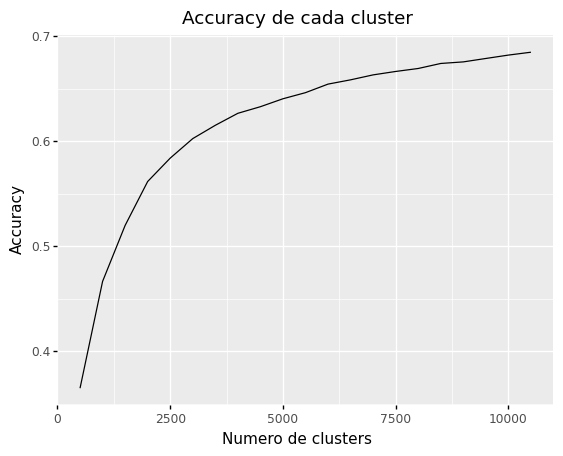

<ggplot: (118168435610)>

In [17]:
from plotnine import *

(ggplot()+aes(x=rango[:-1], y=k_acc_1[:-1,0])+geom_line()+xlab("Numero de clusters")+ylab("Accuracy")+ggtitle("Accuracy de cada cluster"))

In [ ]:
from sklearn.model_selection import KFold
rango = range(25,1301,25)
k_acc = np.zeros(len(rango))
j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    temp = np.zeros(5)
    i=0
    for train_index, test_index in kfold.split(data_matrix_without_nan):
        train = data_matrix_without_nan[train_index, :]
        test = data_matrix_without_nan[test_index, :]

        proc = PLT_processor(0, k)
        acc = proc.process(train, test)

        temp[i] = acc[0]
        i+=1
    k_acc[j] = temp.mean()
    j+=1

In [ ]:
(ggplot()+aes(x=rango, y=k_acc)+geom_line())

# Lematización

In [40]:
data = pd.read_csv(r'../../data/nueva_data/propiedades_codigo.csv', delimiter="\t")

In [42]:
# LEMATIZACION
pd.options.mode.chained_assignment = None # Para evitar que se muestre warnings

# Normalizacion de los conceptos, descripciones y codificaciones
for i in range(len(data)):
    data['Respuesta'][i] = lematize(clean_text(data['Respuesta'][i]))

In [47]:
# Creation of the matrix to make the clustering process
descriptions_matrix_lema = np.zeros( # creatign an empty matrix
    (
        len(data), # the number of data points
        len(model['hola']) # the number of components of the word embedding
    )
)

# matrix filling 
for i,description in enumerate(data['Respuesta']):
    vector = to_vector(description,model)
    descriptions_matrix_lema[i,] = vector

# Concatenate the matrix with the data of each observation
data_matrix_lema = np.concatenate([descriptions_matrix_lema,data], axis=1)

#--------------------------------------------------------------------------------------
# This is the important matrix
# Remove of the 'Nan' data
data_matrix_without_nan_lema = data_matrix_lema[~pd.isnull(data_matrix_lema[:,:300]).any(axis=1)]
#--------------------------------------------------------------------------------------

# reduce the matrix to the importan
data_matrix_without_nan_lema = np.concatenate(
    (data_matrix_without_nan_lema[:,:300],                       # Vector of the description
    np.reshape(data_matrix_without_nan_lema[:,300], (-1, 1)),    # Cue/Concept
    np.reshape(data_matrix_without_nan_lema[:,302], (-1, 1)),    # Codification
    np.reshape(data_matrix_without_nan_lema[:,301], (-1, 1))     # Description of the cue
    ),
    axis = 1
)

C:\Users\dra98\AppData\Local\Temp\ipykernel_12832\2310962255.py:42: RuntimeWarning: invalid value encountered in true_divide
  return vec / np.linalg.norm(vec) # divides the vector by their normal


In [48]:
# K = 500
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k500_acc_top_lema = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan_lema):
    train = data_matrix_without_nan_lema[train_index, :]
    test = data_matrix_without_nan_lema[test_index, :]

    proc = PLT_processor(0)
    acc = proc.process(train, test)

    for j in range(len(tops)):
        k500_acc_top_lema[i,j] = acc[tops[j]]

    i+=1

print(k500_acc_top_lema.mean(axis=0))
print(k500_acc_top_lema.std(axis=0))

[0.36922817 0.41354501 0.43043405 0.45640939 0.52116197]
[0.01145839 0.01107725 0.01111222 0.00949254 0.01011054]


In [49]:
# K = 1000
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k1000_acc_top_lema = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan_lema):
    train = data_matrix_without_nan_lema[train_index, :]
    test = data_matrix_without_nan_lema[test_index, :]

    proc = PLT_processor(0, n_clusters=1000)
    acc = proc.process(train, test)

    for j in range(len(tops)):
        k1000_acc_top_lema[i,j] = acc[tops[j]]

    i+=1

print(k1000_acc_top_lema.mean(axis=0))
print(k1000_acc_top_lema.std(axis=0))

[0.47748691 0.5289647  0.54818443 0.57449755 0.64678264]
[0.00874872 0.00689851 0.00621774 0.00452374 0.00631262]


In [ ]:
# K = N
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
kn_acc_top_lema = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan_lema):
    train = data_matrix_without_nan_lema[train_index, :]
    test = data_matrix_without_nan_lema[test_index, :]

    proc = PLT_processor(0, n_clusters=len(train))
    acc = proc.process(train, test)

    for j in range(len(tops)):
        kn_acc_top_lema[i,j] = acc[tops[j]]

    i+=1

print(kn_acc_top_lema.mean(axis=0))
print(kn_acc_top_lema.std(axis=0))